In [1]:
import tensorflow
import keras

Using TensorFlow backend.


In [2]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

In [3]:
import IPython

In [4]:
my_seed = 42 # 480 could work too
random.seed(my_seed)
np.random.seed(my_seed)
tensorflow.set_random_seed(my_seed)

## Import data & separate train and test

In [5]:
df = pd.read_csv('all_data_info.csv')
#mask = (df['new_filename'].str.startswith('3') & df['in_train'])
mask = df['in_train']
train_3_df = df[mask]
top10 = train_3_df.groupby('artist').count().sort_values(by='title', ascending=False).head(10)

In [11]:
top20 = train_3_df.groupby('artist').count().sort_values(by='title', ascending=False).head(20)

In [23]:
# Copy pictures of top10 artists
from shutil import copy2
input_dir = '/media/mo/My Passport/painters/train/'
output_dir = '/media/mo/My Passport/painters/top10/'
for i in range(len(top10.index)):
    files = list(train_3_df[(train_3_df['artist'] == top10.index[i])]['new_filename'])
    #print(files)
    #random.shuffle(files)
    count=0
    errors=0
    for f in files:
        if os.path.exists(input_dir+f):
            copy2(input_dir+f, output_dir)
            count +=1
        else:
            errors+=1
    print('Copied %d images of %s with %d errors' % (count, top10.index[i], errors))

Copied 412 images of Paul Cezanne with 0 errors
Copied 402 images of Giovanni Battista Piranesi with 0 errors
Copied 399 images of Martiros Saryan with 0 errors
Copied 397 images of Ilya Repin with 0 errors
Copied 393 images of Camille Pissarro with 0 errors
Copied 392 images of Vincent van Gogh with 0 errors
Copied 389 images of Theophile Steinlen with 0 errors
Copied 388 images of Pyotr Konchalovsky with 0 errors
Copied 388 images of Pierre-Auguste Renoir with 0 errors
Copied 388 images of Boris Kustodiev with 0 errors


In [6]:
rand_top10 = list(top10.index)
random.shuffle(rand_top10)
print(rand_top10)

['Pyotr Konchalovsky', 'Ilya Repin', 'Martiros Saryan', 'Pierre-Auguste Renoir', 'Vincent van Gogh', 'Theophile Steinlen', 'Boris Kustodiev', 'Camille Pissarro', 'Paul Cezanne', 'Giovanni Battista Piranesi']


In [8]:
data_dir = '/home/mo/Downloads/painters/'
train_dir = data_dir + 'top10_resized/'

working_train_dir = data_dir + "train/"
working_test_dir = data_dir + "test/"
if (os.path.isdir(working_train_dir) == False):
    os.mkdir(working_train_dir)
    print("created " + working_train_dir)
else:
    print(working_train_dir + " exists")
if (os.path.isdir(working_test_dir) == False):
    os.mkdir(working_test_dir)
    print("created " + working_test_dir)
else:
    print(working_test_dir + " exists")

artist_dirs = []
test_artist_dirs = []
for a in top10.index:
    artist_dirs.append(working_train_dir + a)
    test_artist_dirs.append(working_test_dir + a)

created /home/mo/Downloads/painters/train/
created /home/mo/Downloads/painters/test/


In [9]:
for d in artist_dirs:    
    if (os.path.isdir(d) == False):
        os.mkdir(d)
        print("created " + d)
    else:
        print(d + " exists")

# same for test data 
for d in test_artist_dirs:    
    if (os.path.isdir(d) == False):
        os.mkdir(d)
        print("created " + d)
    else:
        print(d + " exists")

created /home/mo/Downloads/painters/train/Paul Cezanne
created /home/mo/Downloads/painters/train/Giovanni Battista Piranesi
created /home/mo/Downloads/painters/train/Martiros Saryan
created /home/mo/Downloads/painters/train/Ilya Repin
created /home/mo/Downloads/painters/train/Camille Pissarro
created /home/mo/Downloads/painters/train/Vincent van Gogh
created /home/mo/Downloads/painters/train/Theophile Steinlen
created /home/mo/Downloads/painters/train/Pyotr Konchalovsky
created /home/mo/Downloads/painters/train/Pierre-Auguste Renoir
created /home/mo/Downloads/painters/train/Boris Kustodiev
created /home/mo/Downloads/painters/test/Paul Cezanne
created /home/mo/Downloads/painters/test/Giovanni Battista Piranesi
created /home/mo/Downloads/painters/test/Martiros Saryan
created /home/mo/Downloads/painters/test/Ilya Repin
created /home/mo/Downloads/painters/test/Camille Pissarro
created /home/mo/Downloads/painters/test/Vincent van Gogh
created /home/mo/Downloads/painters/test/Theophile Stein

In [10]:
from shutil import copy2

test_num = 40

for i in range(len(top10.index)):
    test_count = 0
    train_count = 0
    files = list(train_3_df[(train_3_df['artist'] == top10.index[i])]['new_filename'])
    random.shuffle(files)
    for f in files:
        if (test_count < test_num) and os.path.exists(train_dir+f) and not os.path.exists(test_artist_dirs[i]+f):
            copy2(train_dir+f, test_artist_dirs[i])
            test_count +=1
        elif os.path.exists(train_dir+f) and not os.path.exists(artist_dirs[i]+f):
            copy2(train_dir+f, artist_dirs[i])
            train_count +=1
    print('Copied to %s : %s images' % (str(test_artist_dirs[i]), str(test_count)))
    print('Copied to %s : %s images' % (str(artist_dirs[i]), str(train_count)))

Copied to /home/mo/Downloads/painters/test/Paul Cezanne : 40 images
Copied to /home/mo/Downloads/painters/train/Paul Cezanne : 372 images
Copied to /home/mo/Downloads/painters/test/Giovanni Battista Piranesi : 40 images
Copied to /home/mo/Downloads/painters/train/Giovanni Battista Piranesi : 362 images
Copied to /home/mo/Downloads/painters/test/Martiros Saryan : 40 images
Copied to /home/mo/Downloads/painters/train/Martiros Saryan : 359 images
Copied to /home/mo/Downloads/painters/test/Ilya Repin : 40 images
Copied to /home/mo/Downloads/painters/train/Ilya Repin : 357 images
Copied to /home/mo/Downloads/painters/test/Camille Pissarro : 40 images
Copied to /home/mo/Downloads/painters/train/Camille Pissarro : 353 images
Copied to /home/mo/Downloads/painters/test/Vincent van Gogh : 40 images
Copied to /home/mo/Downloads/painters/train/Vincent van Gogh : 352 images
Copied to /home/mo/Downloads/painters/test/Theophile Steinlen : 40 images
Copied to /home/mo/Downloads/painters/train/Theophil

## Import the model for transfer learning

In [11]:
from tensorflow.python.keras.applications import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D

num_classes = 10 

# https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
weights_notop_path = ''

# declare new Sequential model
# meaning each layer is in sequence, one after the other. 
# apparently there can be non-sequential neural networks... wow!
model = Sequential()

# now let's set up the first layers
model.add(ResNet50(    # add a whole ResNet50 model
  include_top=False,          # without the last layer
  weights='imagenet', # and with the "notop" weights file
  pooling='avg' # means collapse extra "channels" into 1D tensor by taking an avg across channels
))


# Now lets add a "Dense" layer to make predictions
model.add(Dense(
  num_classes, # this last layer just has 2 nodes
  activation='softmax' # apply softmax function to turn values of this layer into probabilities
))

# do not train the first layer
# because it is already smart
# it learned cool patterns from ImageNet
model.layers[0].trainable = False

Instructions for updating:
Colocations handled automatically by placer.


In [12]:
model.compile(
  optimizer='sgd', # stochastic gradient descent (how to update Dense connections during training)
  loss='categorical_crossentropy', # aka "log loss" -- the cost function to minimize 
  # so 'optimizer' algorithm will minimize 'loss' function
  metrics=['accuracy'] # ask it to report % of correct predictions
)

In [13]:
from tensorflow.python.keras.applications.resnet50 import preprocess_input
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator

image_size = 224

data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)

data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True,
                                   rotation_range=20,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2)

train_generator_with_aug = data_generator_with_aug.flow_from_directory(
        working_train_dir,
        target_size=(image_size, image_size),
        batch_size=4,
        class_mode='categorical')

validation_generator = data_generator_no_aug.flow_from_directory(
        working_test_dir,
        target_size=(image_size, image_size),
        class_mode='categorical')

Found 3547 images belonging to 10 classes.
Found 400 images belonging to 10 classes.


## Train the model

In [14]:
history_aug = model.fit_generator(
        train_generator_with_aug,
        steps_per_epoch=10,
        epochs=1,
        validation_data=validation_generator,
        validation_steps=1)

Instructions for updating:
Use tf.cast instead.
887/887 [==============================] - 466s 525ms/step - loss: 1.4672 - acc: 0.4838 - val_loss: 0.9556 - val_acc: 0.6750


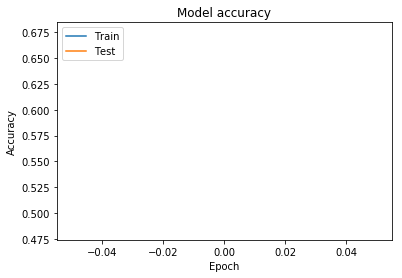

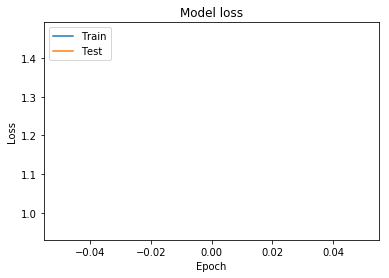

In [15]:
plt.plot(history_aug.history['acc'])
plt.plot(history_aug.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_aug.history['loss'])
plt.plot(history_aug.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Check the predictions

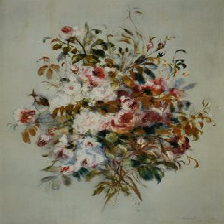

In [20]:
import PIL.Image as Image

rand_top10 = list(top10.index)
random.shuffle(rand_top10)
true_artist = rand_top10[0]
pictures = list(train_3_df[(train_3_df['artist'] == true_artist)]['new_filename'])
img = random.choice(pictures)
image_name = train_dir + img
image = Image.open(image_name).resize((image_size, image_size))
image

In [21]:
print('Artist: ' + true_artist)

Artist: Pierre-Auguste Renoir


In [22]:
image = np.array(image)/255.0
result = model.predict(image[np.newaxis, ...])
predicted_class = np.argmax(result[0], axis=-1)
result

array([[1.6388966e-02, 3.2351431e-02, 4.7901586e-02, 7.3087554e-05,
        7.5798361e-03, 1.3540866e-03, 7.1843190e-04, 1.3920990e-05,
        8.9084280e-01, 2.7758589e-03]], dtype=float32)

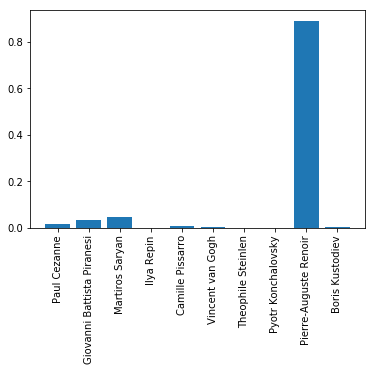

In [23]:
plt.bar(range(10), result[0])
plt.xticks(range(10), top10.index, rotation=90)
plt.show()

In [24]:
df

,artist,date,genre,pixelsx,pixelsy,size_bytes,source,style,title,artist_group,in_train,new_filename
0,Barnett Newman,1955.0,abstract,15530.0,6911.0,9201912.0,wikiart,Color Field Painting,Uriel,train_only,True,102257.jpg
1,Barnett Newman,1950.0,abstract,14559.0,6866.0,8867532.0,wikiart,Color Field Painting,Vir Heroicus Sublimis,train_only,True,75232.jpg
2,kiri nichol,2013.0,NaN,9003.0,9004.0,1756681.0,NaN,Neoplasticism,NaN,test_only,False,32145.jpg
3,kiri nichol,2013.0,NaN,9003.0,9004.0,1942046.0,NaN,Neoplasticism,NaN,test_only,False,20304.jpg
4,kiri nichol,2013.0,NaN,9003.0,9004.0,1526212.0,NaN,Neoplasticism,NaN,test_only,False,836.jpg
5,Tosa Mitsuoki,NaN,mythological painting,25528.0,3000.0,10496349.0,wikiart,Yamato-e,Night March of a Hundred Demons (left half),train_only,True,29855.jpg
6,Barnett Newman,NaN,abstract,7345.0,8640.0,6383948.0,wikiart,Color Field Painting,"Who’s Afraid of Red, Yellow and Blue II",train_only,True,62252.jpg
7,Hiroshige,1838,bird-and-flower painting,6483.0,9276.0,12762418.0,wikiart,Ukiyo-e,Small Bird on a Branch of Kaidozakura,train_and_test,False,49823.jpg
8,Barnett Newman,1963.0,abstract,6049.0,8206.0,1135960.0,wikiart,Color Field Painting,Black Fire I,train_only,True,63861.jpg
9,Franz Richard Unterberger,NaN,cityscape,6238.0,7352.0,7896792.0,wikiart,Romanticism,Procession in Naples,train_and_test,False,84512.jpg


In [26]:
history_aug.history['loss']

[1.4671297390964424]